<a href="https://colab.research.google.com/github/lamantinushka/cam_summarisation/blob/master/GPT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction
In this part of the project we investigate potential of GPT-2 architecture in unsupervised summarization task. GPT-2 is a self-attentive models consisting of sequentially stacked transformer decoders. It is a model with 1.5 billion parameters trained for language modeling task in 40GB of Internet text. 

Firstly we try using GPT-2 with the weights that were released. Then we finetune model on the set of all sentences from the CAM outputs and apply finetuned model.

We use four techniques for decoding:
- greedy decoding (choose the most probable token on each step)
- soft decoding (choose token with predicted probabilities)
- beam search (maintain heap of most probable decodings on each step)
- **UPD** diverse beam search (penalising hypothsis that are expansions of the same parent node)

In all cases we start with the phrase "\<object1> is better than \<object2> because". It is also possible to feed previous sentence to the model. But as it is shown, feeding question "Why is \<object1> better than \<object2>?" as a condition makes almost no difference in model performance.

# Loading data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import json

In [0]:
data = []
for line in open('drive/My Drive/summarization/mined_bow_str.json', 'r'):
    data.append(json.loads(line))

In [0]:
# usefull function that extracts all supporting sentences from the CAM output
def write_sentences(sample, sentences = None):
    if sentences is None:
        sentences = []
    for s in sample['object1']['sentences']:
        sentences.append(s['text'] + '\n')
    for s in sample['object2']['sentences']:
        sentences.append(s['text'] + '\n')
    return sentences

Let's choose some samples to compare model's performance

In [5]:
samples = [data[4], data[155], data[228]]

for s in samples:
  print(s['object1']['name'] + ' vs ' + s['object2']['name'])

python vs java
toyota vs nissan
tea vs juice


# Decoding techniques

In [0]:
def decode_greedy(model, begining, maxlen = 20):
    result = torch.tensor(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(begining))).view(1, -1).cuda()
    for i in range(maxlen):
        with torch.no_grad():
            predictions, _ = model(result)
            pred = torch.argmax(predictions[0, -1, :]).item()
            result = torch.cat([result, pred*torch.ones(1, 1, dtype = torch.long, device = 'cuda')], dim = -1)
    return result

In [0]:
def decode_soft(model, begining, maxlen = 20, temperature = 1.0):
    result = torch.tensor(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(begining))).view(1, -1).cuda()
    for i in range(maxlen):
        with torch.no_grad():
            predictions, _ = model(result)
            word_weights = predictions[0, -1].div(temperature).exp().cpu() 
            pred = torch.multinomial(word_weights, 1)[0].cuda()
            result = torch.cat([result, pred*torch.ones(1, 1, dtype = torch.long, device = 'cuda')], dim = -1)
    return result

In [0]:
from heapq import heappop, heappush

#beam-search step
def make_decoding_step(heap, gpt_model, heap_size = 10, beam_size = 3, past = None):
    result = []
    for node in heap:
        n = node[1].shape[-1]
        p = node[0]
        with torch.no_grad():
            if past is not None:
                predictions, _ = model(node[1], past = past)
            else:
                predictions, _ = model(node[1])
            predictions = predictions[0, -1]
            predictions -= predictions.min()
            probs = predictions.exp()
            probs /= probs.sum()
        top_p, top_i = torch.topk(probs, beam_size)
        for i in range(beam_size):
            mean_prob = (p*n - torch.log(top_p[i]))/(n + 1)
            prefics = torch.cat([node[1], top_i[i]*torch.ones(1, 1, dtype = torch.long, device = 'cuda')], 
                                dim = -1)
            heappush(result, (mean_prob, prefics))
            result = result[:heap_size]
    return result

In [0]:
def make_decoding_step_with_penalty(heap, gpt_model, heap_size = 10, beam_size = 3, past = None, penalty = 0.1):
    result = []
    for node in heap:
        n = node[1].shape[-1]
        p = node[0]
        with torch.no_grad():
            if past is not None:
                predictions, _ = model(node[1], past = past)
            else:
                predictions, _ = model(node[1])
            predictions = predictions[0, -1]
            predictions -= predictions.min()
            probs = predictions.exp()
            probs /= probs.sum()
        top_p, top_i = torch.topk(probs, beam_size)
        for i in range(beam_size):
            score = p - torch.log(top_p[i]) + penalty * i
            prefics = torch.cat([node[1], top_i[i]*torch.ones(1, 1, dtype = torch.long, device = 'cuda')], 
                                dim = -1)
            heappush(result, (score, prefics))
            result = result[:heap_size]
    return result

#Raw GPT-2

In [0]:
!pip install pytorch-pretrained-bert

In [0]:
import numpy as np
import pandas as pd
import torch
from pytorch_pretrained_bert import *
from torch.nn import CrossEntropyLoss, KLDivLoss
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [12]:
model = GPT2LMHeadModel.from_pretrained('gpt2').cuda()
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

100%|██████████| 456318/456318 [00:00<00:00, 497125.70B/s]


In [0]:
decode = decode_greedy

for s in samples:
    name1 = s['object1']['name']
    name2 = s['object2']['name']

    if s['object1']['points']['none'] > s['object2']['points']['none']:
        begining = '{} is better than {} because'.format(name1, name2)
    else:
        begining = '{} is better than {} because'.format(name2, name1)

    result = decode(model, begining, maxlen = 30)
    tokens = tokenizer.convert_ids_to_tokens(result.view(-1).detach().cpu().numpy())

    print(name1 + ' vs ' + name2)
    print(''.join(tokens).replace('Ġ', ' ').replace('Ċ', ' '))
    print()

python vs java
python is better than java because it's a bit more flexible.  The main difference between java and java-lang is that java-lang is a bit more flexible. 

toyota vs nissan
nissan is better than toyota because it's a better car.  The car is a bit more expensive than the Toyota Prius, but it's still a better car than the

tea vs juice
juice is better than tea because it's more concentrated and it's more concentrated.  The best way to get the best flavor is to use a lot of water.  



In [0]:
decode = decode_soft

for s in samples:
    name1 = s['object1']['name']
    name2 = s['object2']['name']

    if s['object1']['points']['none'] > s['object2']['points']['none']:
        begining = '{} is better than {} because'.format(name1, name2)
    else:
        begining = '{} is better than {} because'.format(name2, name1)

    print(name1 + ' vs ' + name2)
    for i in range(3):
        result = decode(model, begining, maxlen = 10, temperature = 2)
        tokens = tokenizer.convert_ids_to_tokens(result.view(-1).detach().cpu().numpy())
        print(''.join(tokens).replace('Ġ', ' ').replace('Ċ', ' '))
    print()

python vs java
python is better than java because without conveyed Brook compositions slices Rav Rh legislature Binary bad
python is better than java because audience varies automated", hasn't said done.- Ross
python is better than java because reass purse demos renderingSTRUCT DUPIBRTF impossible

toyota vs nissan
nissan is better than toyota because of holiday feel Titan Active Stupidit horse ALL benefit
nissan is better than toyota because adolescent dressesoti%; GT brazenly ren Fro haunted
nissan is better than toyota because matter using the charging iconic patent 4 pressed / revolver

tea vs juice
juice is better than tea because. reveå§ margin pleasures.Its 165agent weight
juice is better than tea because it peace m traditions hor xaily ot %aches
juice is better than tea because, again tell warned Sill define digital ignition DATA



In [0]:
maxlen = 20

for s in samples:
    name1 = s['object1']['name']
    name2 = s['object2']['name']

    if s['object1']['points']['none'] > s['object2']['points']['none']:
        begining = '{} is better than {} because'.format(name1, name2)
    else:
        begining = '{} is better than {} because'.format(name2, name1)

    print(name1 + ' vs ' + name2)

    result = torch.tensor(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(begining))).view(1, -1).cuda()
    heap = [(0.0, result)]

    for i in range(maxlen):
        heap = make_decoding_step(heap, model, heap_size=15, beam_size = 10)

    for i in range(len(heap)):
        sample = heappop(heap)[1]
        tokens = tokenizer.convert_ids_to_tokens(sample.view(-1).detach().cpu().numpy())
        print(''.join(tokens).replace('Ġ', ' ').replace('Ċ', ' '))
    print()

python vs java
python is better than java because it's easier to use.  If you want to learn more about Java, check out the
python is better than java because it's easier to use.  If you want to learn more about java, check out the
python is better than java because it's easier to use.  If you want to learn more about Java, check out this
python is better than java because it's easier to use.  If you want to learn more about Java, you can read
python is better than java because it's easier to use.  If you want to learn more about Java, check out my
python is better than java because it's easier to use.  If you want to learn more about how to use java,
python is better than java because it's easier to use.  If you want to learn more about Java, you can check
python is better than java because it's easier to use.  If you want to learn more about Java, check out Java
python is better than java because it's easier to use.  If you want to learn more about Java, you can find
python is better 

In [29]:
maxlen = 20

for s in samples:
    name1 = s['object1']['name']
    name2 = s['object2']['name']

    if s['object1']['points']['none'] > s['object2']['points']['none']:
        begining = '{} is better than {} because'.format(name1, name2)
    else:
        begining = '{} is better than {} because'.format(name2, name1)

    print(name1 + ' vs ' + name2)

    result = torch.tensor(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(begining))).view(1, -1).cuda()
    heap = [(0.0, result)]

    for i in range(maxlen):
        heap = make_decoding_step_with_penalty(heap, model, heap_size=15, beam_size = 10, penalty = 1.0)

    for i in range(len(heap)):
        sample = heappop(heap)
        sample = sample[1]
        tokens = tokenizer.convert_ids_to_tokens(sample.view(-1).detach().cpu().numpy())
        print(''.join(tokens).replace('Ġ', ' ').replace('Ċ', ' '))
    print()

python vs java
python is better than java because it's faster and easier to use.  The main difference between java and java2 is that
python is better than java because it's faster and easier to use.  If you want to learn more about Java, check
python is better than java because it's faster and easier to use.  The main difference between java and java is that java
python is better than java because it's faster and easier to use.  The main difference between java and java2 is the
python is better than java because it's faster and easier to use.  The main difference between java and java-2.
python is better than java because it's faster and easier to use.  If you want to learn more about Java, you
python is better than java because it's faster and easier to use.  If you want to learn more about Java, read
python is better than java because it's faster and easier to use.  The main difference between java and java2 is in
python is better than java because it's faster and easier to use.  If 

# Finetuning

In [0]:
def dataloder(lines, maxlen, n_steps):
    for i in range(n_steps):
        tokens = None
        while tokens is None:
            try:
                idx = np.random.choice(len(lines))
                sentence = lines[idx]
                tokens = torch.tensor(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentence))).cuda()
            except:
                tokens = None
        yield tokens.view(1, -1)

In [0]:
with open('drive/My Drive/summarization/sentences.txt', 'r') as file:
    lines = file.readlines()

In [0]:
class Args():
  def __init__(self):
    pass

args = Args()
args.max_steps = 100000
args.learning_rate = 5e-5
args.weight_decay = 0.01
args.adam_epsilon = 1e-9
args.warmup_steps = 2000
args.maxlen = 1024
args.device = torch.device('cuda') 

In [0]:
import os
losses = []
tr_losses = []

def train(args, lines, model):
    train_dataloader = dataloder(lines, args.maxlen, args.max_steps)

    t_total = args.max_steps

    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': args.weight_decay},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
    #print(t_total)
    optimizer = BertAdam(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon, 
                         t_total = t_total, warmup = 0.05)

    print("***** Running training *****")
    print("  Num examples = {}".format(t_total))
    #logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)
    #logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    #set_seed(args)  # Added here for reproducibility (even between python 2 and 3)
    for step, batch in enumerate(train_dataloader):
        inputs, labels =(batch, batch)
        inputs = inputs.to(args.device)
        labels = labels.to(args.device)
        model.train()
        outputs = model(inputs, lm_labels=labels)
        loss = outputs#[0]  # model outputs are always tuple in transformers (see doc)

        loss.backward()
        optimizer.step()
        model.zero_grad()

        losses.append(loss.item())

        global_step += 1
        tr_loss += loss.item()
        tr_losses.append(tr_loss/global_step)

        if global_step % 200 == 0:
            checkpoint_prefix = 'checkpoint'
            # Save model checkpoint
            if global_step % 2000 == 0:
                output_dir = 'model'
                if not os.path.exists(output_dir):
                    os.makedirs(output_dir)
                torch.save(model, os.path.join(output_dir, '{}-{}'.format(checkpoint_prefix, global_step)))

            clear_output()
            print("***** Running training *****")
            print("  Num examples = {}".format(t_total))
            #print("Saving model checkpoint to %s", output_dir)
            plt.plot(losses[::10], label = 'train_loss')
            plt.plot(tr_losses[::10], label = 'smoothed_loss')
            plt.legend()
            plt.show()
            
    return global_step, tr_loss / global_step

***** Running training *****
  Num examples = 100000


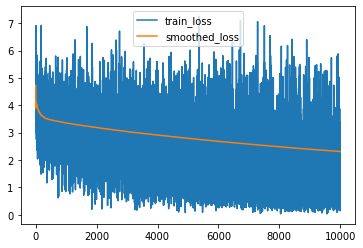

(100000, 2.3110702802693286)

In [0]:
model = model.cuda()
train(args, lines, model)

In [0]:
decode = decode_greedy

for s in samples:
    name1 = s['object1']['name']
    name2 = s['object2']['name']

    if s['object1']['points']['none'] > s['object2']['points']['none']:
        begining = '{} is better than {} because'.format(name1, name2)
    else:
        begining = '{} is better than {} because'.format(name2, name1)

    result = decode(model, begining, maxlen = 30)
    tokens = tokenizer.convert_ids_to_tokens(result.view(-1).detach().cpu().numpy())

    print(name1 + ' vs ' + name2)
    print(''.join(tokens).replace('Ġ', ' ').replace('Ċ', ' '))
    print()

python vs java
python is better than java because it is more readable.  3.  3.1) I found that java is much easier to read than ruby.  3

toyota vs nissan
nissan is better than toyota because of the better quality of the interiors.     issan is better than toyota is better than nissan.  Toyota

tea vs juice
juice is better than tea because it lasts.  "  "   "   "   "   "   " 



In [0]:
decode = decode_soft

for s in samples:
    name1 = s['object1']['name']
    name2 = s['object2']['name']

    if s['object1']['points']['none'] > s['object2']['points']['none']:
        begining = '{} is better than {} because'.format(name1, name2)
    else:
        begining = '{} is better than {} because'.format(name2, name1)

    print(name1 + ' vs ' + name2)
    for i in range(3):
        result = decode(model, begining, maxlen = 10, temperature = 10)
        tokens = tokenizer.convert_ids_to_tokens(result.view(-1).detach().cpu().numpy())
        print(''.join(tokens).replace('Ġ', ' ').replace('Ċ', ' '))
    print()

python vs java
python is better than java because Medic Beat Verifymost ImageØ§ÙĦ Tamil Cinderella Gospel pref
python is better than java becauseuma666690 teasp continuous thunder distribute detainedide accusation
python is better than java because fallacy knack jumps Hut quizzidge periods mascul stimulate cream

toyota vs nissan
nissan is better than toyota because stimulating humanities ninety proponentsunderlict455 photographyabled174
nissan is better than toyota because voidSEE debilitating Byron bombardmentScar likely explosion shippingãĤ¤ãĥĪ
nissan is better than toyota because adaptation ends turbulence CAN requestsgiven ratherLED Ae rockets

tea vs juice
juice is better than tea becauseRand Controller Fistcraftros AquJimmyinski supreme rival
juice is better than tea because hunger MysticGS subscriberaspers rebukeUNE snippetsiancescreen
juice is better than tea becauseasures nascent BottCrime besides Monarcharsity poetry fab liberals



In [0]:
maxlen = 20

for s in samples:
    name1 = s['object1']['name']
    name2 = s['object2']['name']

    if s['object1']['points']['none'] > s['object2']['points']['none']:
        begining = '{} is better than {} because'.format(name1, name2)
    else:
        begining = '{} is better than {} because'.format(name2, name1)

    print(name1 + ' vs ' + name2)

    result = torch.tensor(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(begining))).view(1, -1).cuda()
    heap = [(0.0, result)]

    for i in range(maxlen):
        heap = make_decoding_step(heap, model, heap_size=15, beam_size = 10)

    for i in range(len(heap)):
        sample = heappop(heap)[1]
        tokens = tokenizer.convert_ids_to_tokens(sample.view(-1).detach().cpu().numpy())
        print(''.join(tokens).replace('Ġ', ' ').replace('Ċ', ' '))
    print()

python vs java
python is better than java because it is more readable.  "  "  "  "  "
python is better than java because it is more readable.  3.  4.  5.  6
python is better than java because it is more readable.  "  "  "  " "  
python is better than java because it is more readable.  "  "  " "  " " 
python is better than java because it is more readable.  "  "  "  "   "
python is better than java because it is more readable.  3.  4.  5.  5
python is better than java because it is more readable.  3.  4.  5.   6
python is better than java because it is more readable.  "  "  "  "  p
python is better than java because it is more readable.  3.  4.  5.  4
python is better than java because it is more readable.  3.  4.  5.  7
python is better than java because it is more readable.  "  "  "  "  '
python is better than java because it is more readable.  "  "  "  "   .
python is better than java because it is more readable.  "  "  "  "  ''
python is better than java because it is more readable.

# Outline

- GPT-2 is capable of generating at least one coherent sentence. 
- Pretraining on the single sentences from CAM output allows to adapt model to the domain, but at the same time stimulates it to generate only one sentence.
- Beam search in this case does not give the desirable diversity of the summaries.